# Study the VGG16 convolutional neural network

The VGG16 architecture is a popular convolutional neural network design, which was used in the Large Scale Visual Recognition Challenge in 2014 (see [here](http://www.image-net.org/challenges/LSVRC/2014/results)). The network was trained on a subset of the ImageNet datset containing 15 mio. images using roughly 1000 images in 1000 categories. A good overview over the details of the network can be found [here](https://neurohive.io/en/popular-networks/vgg16/). The following visualization of the VGG16 architecture is taken from there:

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In the following, we will go into the details how we can study the model by visualizing the convolutional layers and performing a gradient analysis.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import keras
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import numpy as np
from scipy.signal import convolve2d
import matplotlib
import matplotlib.pyplot as plt
import json

Using TensorFlow backend.


## Set up the VGG16 model with pre-trained weights

Since the training of the VGG16 model is extremely computational expensive, we download the already trained weights. Keras already provides this functionality for VGG16 and many other popular architectures.

In [2]:
model = VGG16()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## Load an image for classification

Since the dense layers after the convolutional part of the network expect a specific size of the input image, we have to provide an image of the correct size. The following code loads and crops an image to the size 224 on 224 pixels.

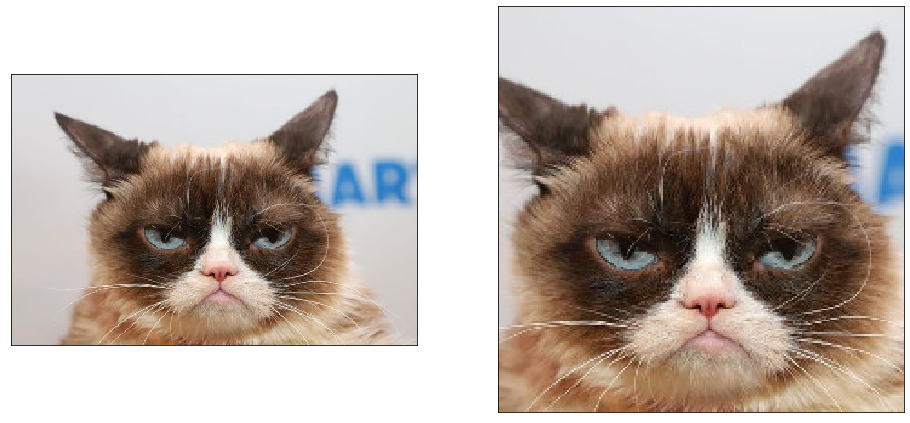

In [3]:
# Helper function to crop an image at the center to 224 on 224 pixels
def center_crop(img, new_width=224, new_height=224):
    width = img.shape[1]
    height = img.shape[0]
    
    left = int(np.ceil((width - new_width) / 2))
    right = width - int(np.floor((width - new_width) / 2))
    top = int(np.ceil((height - new_height) / 2))
    bottom = height - int(np.floor((height - new_height) / 2))
    
    if any(np.array([left, right, top, bottom]) < 0):
        raise Exception("Cropped image has to be exactly of size 224x224. Your input image is too small.")

    return img[top:bottom, left:right]

# Load the image from disk
img = load_img('cat.jpg')

# Convert the binary data to a numpy array
imgarr = img_to_array(img)

# Crop the array at the center on 224x224
imgarr = center_crop(imgarr)

# Plot the original image and the cropped version
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(img)
plt.subplot(1, 2, 2)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(imgarr.astype(np.uint8));

## Perform the classification

First, the image data has to be per-processed to fit the expected value ranges of the model. Then, we can perform the forward pass through the network and can predict the most probable class to which the image belongs.

In [4]:
# Preprocess the image data such as needed for the pre-trained VGG16 model
# The preprocessing includes the normalization of the pixel values to the range [0, 1]
# and reshaping the array to the shape expected by Keras.
imgarr_preproc = np.expand_dims(imgarr.copy(), axis=0)
imgarr_preproc = preprocess_input(imgarr_preproc)

# Perform the prediction of the class which the image belongs to
pred = model.predict(imgarr_preproc)

# Translate the prediction to the human-readable class labels
labels = decode_predictions(pred, top=5)

# Print the class labels for the 5 classes with the largest probability score
for i, label in enumerate(labels[0]):
    print("Rank: {:}, Label: {:}, Score: {:.3f}".format(i + 1, label[1], label[2]))

Rank: 1, Label: Persian_cat, Score: 0.451
Rank: 2, Label: Siamese_cat, Score: 0.314
Rank: 3, Label: lynx, Score: 0.069
Rank: 4, Label: tabby, Score: 0.041
Rank: 5, Label: computer_keyboard, Score: 0.015


## Visualize the convolutional filters

To visualize how the network processes the image, we can visualize the output after each convolutional filter. By applying a heatmap, we can study which parts of the image are highlighted and passed down to the next layer.

In [5]:
# Go through the layers of the VGG16 model and print information about
# the convolutional layers.
for i, layer in enumerate(model.layers):
    if 'conv' in layer.name:
        print("Index: {}, Name: {}, Shapes: {} -> {}".format(i, layer.name, layer.input.shape, layer.output.shape))

Index: 1, Name: block1_conv1, Shapes: (?, 224, 224, 3) -> (?, 224, 224, 64)
Index: 2, Name: block1_conv2, Shapes: (?, 224, 224, 64) -> (?, 224, 224, 64)
Index: 4, Name: block2_conv1, Shapes: (?, 112, 112, 64) -> (?, 112, 112, 128)
Index: 5, Name: block2_conv2, Shapes: (?, 112, 112, 128) -> (?, 112, 112, 128)
Index: 7, Name: block3_conv1, Shapes: (?, 56, 56, 128) -> (?, 56, 56, 256)
Index: 8, Name: block3_conv2, Shapes: (?, 56, 56, 256) -> (?, 56, 56, 256)
Index: 9, Name: block3_conv3, Shapes: (?, 56, 56, 256) -> (?, 56, 56, 256)
Index: 11, Name: block4_conv1, Shapes: (?, 28, 28, 256) -> (?, 28, 28, 512)
Index: 12, Name: block4_conv2, Shapes: (?, 28, 28, 512) -> (?, 28, 28, 512)
Index: 13, Name: block4_conv3, Shapes: (?, 28, 28, 512) -> (?, 28, 28, 512)
Index: 15, Name: block5_conv1, Shapes: (?, 14, 14, 512) -> (?, 14, 14, 512)
Index: 16, Name: block5_conv2, Shapes: (?, 14, 14, 512) -> (?, 14, 14, 512)
Index: 17, Name: block5_conv3, Shapes: (?, 14, 14, 512) -> (?, 14, 14, 512)


## Plot the feature maps

To plot the feature maps of a convolutional layer, we have to redefine a new model, which outputs the respective tensor. Then, we can study which parts of the image are highlighted by which feature map.

Shape of the feature maps tensor: (1, 224, 224, 64)


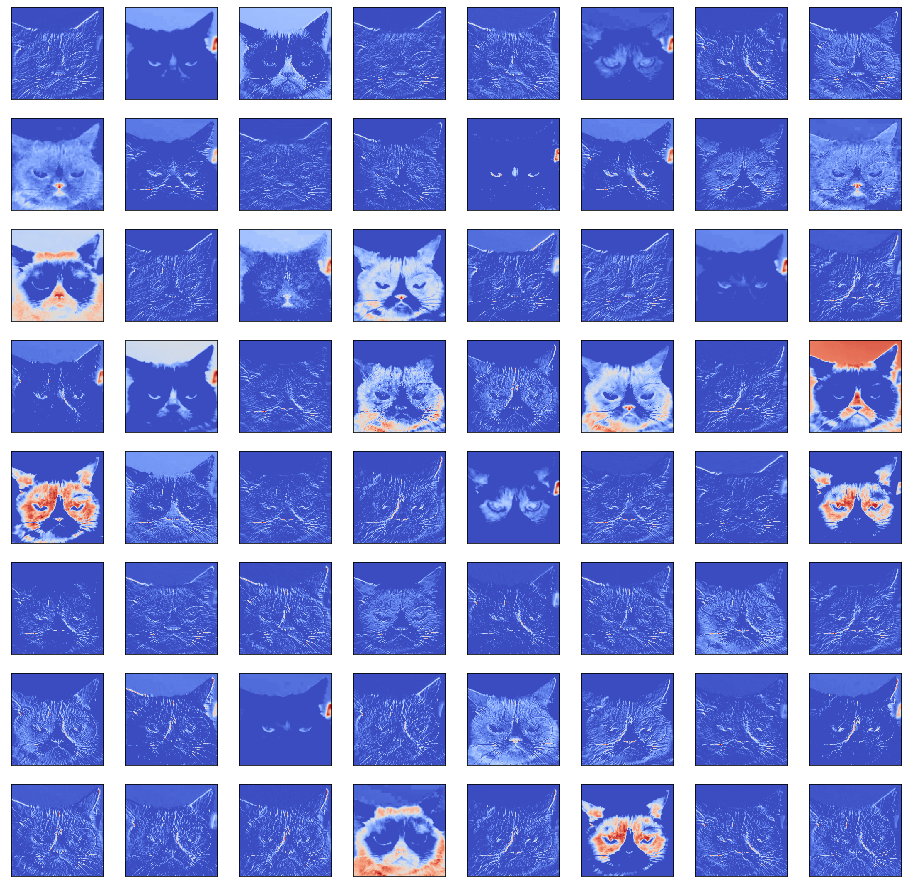

In [6]:
# Build a model which outputs the feature maps
conv_layer_index = 1
model2 = Model(inputs=model.inputs, outputs=model.layers[conv_layer_index].output)

# Compute the feature maps for the input image and print the shape of the tensor
feature_maps = model2.predict(imgarr_preproc)
print("Shape of the feature maps tensor: {}".format(feature_maps.shape))

# Plot the feature maps
size = np.ceil(np.sqrt(feature_maps.shape[-1]))
plt.figure(figsize=(16, 16))
for i in range(feature_maps.shape[-1]):
    f = feature_maps[0, :, :, i]
    f = (f - f.min()) / (f.max() - f.min())
    ax = plt.subplot(size, size, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f, cmap="coolwarm")

## Plot the filter weights used for the feature maps

Finally, we can have a look at the filter that produced the feature maps above.

Shape of filter weights: (3, 3, 3, 64)


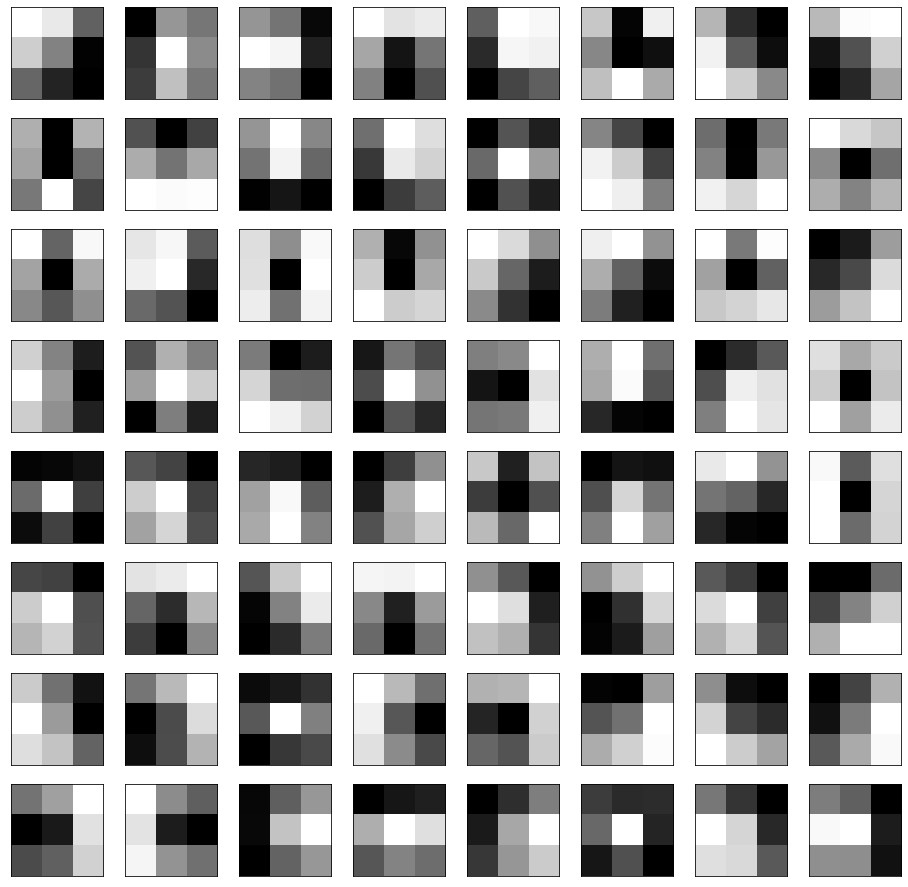

In [7]:
# Get the filter weights form the network and print the shape of the tensor
filters, _ = model.layers[conv_layer_index].get_weights()
print("Shape of filter weights: {}".format(filters.shape))

# Plot the filters
size = np.ceil(np.sqrt(filters.shape[-1]))
plt.figure(figsize=(16, 16))
for i in range(filters.shape[-1]):
    f = np.mean(filters[:, :, :, i], axis=2)
    f = (f - f.min()) / (f.max() - f.min())
    ax = plt.subplot(size, size, i + 1)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(f, cmap="gray")

## Perform a gradient analysis

Next, we want to know which parts of the image contributed most to the classification. To do so, we perform a gradient analysis of the network function.

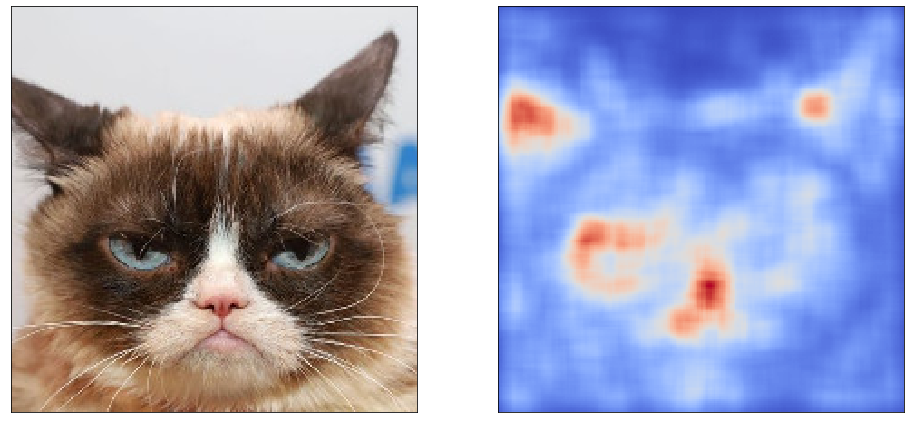

In [8]:
# Function computing the gradients from the given output node to the input tensor
# The output node is selected by the argument `index`.
def compute_grads(index):
    # Get operation to compute the gradients from the output at the given index to the input tensor
    grads_op = keras.backend.gradients(model.layers[-1].output[:, index], model.layers[0].input)
    # Declare a function from the operation
    grads_func = keras.backend.function([model.layers[0].input], grads_op)
    # Perform the computation
    grads = grads_func([imgarr_preproc])
    
    # Post-process the gradients by taking the average of the absolute values.
    # In addition, we average the gradients along the color axis of the tensor
    # and normalize the values to the range [0, 1].
    grads = np.mean(np.abs(grads[0][0, :, :, :]), axis=-1)
    grads = convolve2d(grads, np.ones((16, 16)), mode="same")
    grads = (grads - grads.min()) / (grads.max() - grads.min())
    
    return grads

# Perform the gradient computation with post-processing
grads = compute_grads(pred[0].argmax())

# Plot the original image and the visualization of the sensitivity of
# the predicted class to the input pixels
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(imgarr.astype(np.uint8))
plt.subplot(1, 2, 2)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(grads, cmap="coolwarm");

## Analyze the difference between two output nodes

What makes the network to classify the image as the one class not the other? We can also compare the sensitivity to different output nodes and draw conclusion from the differences.

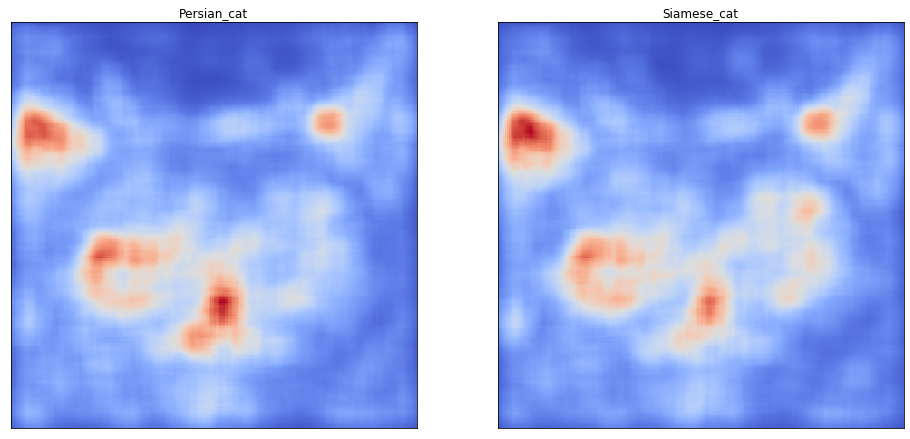

In [9]:
# Get the labels for the output nodes of the network and compute maps,
# which can translate the human-readable name to the index.
fpath = keras.utils.get_file(
            'imagenet_class_index.json',
            'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json',
            cache_subdir='models',
            file_hash='c2c37ea517e94d9795004a39431a14cb')
labelsdict = json.load(open(fpath, "r"))
# Map: Index of the output node to name
idx2label = {int(key): labelsdict[key][1] for key in labelsdict}
# Map: Name to the index of the output node
label2idx = {labelsdict[key][1]: int(key) for key in labelsdict}

# Let's compare two different output nodes
label1 = 'Persian_cat'
label2 = 'Siamese_cat'
grads1 = compute_grads(label2idx[label1])
grads2 = compute_grads(label2idx[label2])

# Plot the analysis
plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.title(label1)
plt.imshow(grads1, cmap="coolwarm")
plt.subplot(1, 2, 2)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.title(label2)
plt.imshow(grads2, cmap="coolwarm");

## Closure test

Let's make a test to check whether the conclusions drawn from the analyses above hold true. Therefore, we "remove" parts of the image, which are important for a specific classification and observe the response from the network.

Does the network behave as expected?

Rank: 1, Label: Siamese_cat, Score: 0.987
Rank: 2, Label: lynx, Score: 0.003
Rank: 3, Label: Persian_cat, Score: 0.003
Rank: 4, Label: tabby, Score: 0.002
Rank: 5, Label: Egyptian_cat, Score: 0.001


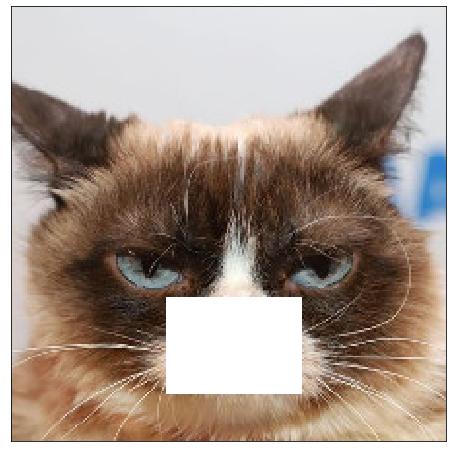

In [10]:
# Make a copy of the pixel values of the image and "remove" a part of the image
# by setting the color to the RGB values of white (255, 255, 255).
imgarr2 = imgarr.copy()
imgarr2[150:200, 80:150, :] = 255

# Plot the altered image
plt.figure(figsize=(8, 8))
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.imshow(imgarr2.astype(np.uint8))

# Preprocess the new image
imgarr2_preproc = np.expand_dims(imgarr2.copy(), axis=0)
imgarr2_preproc = preprocess_input(imgarr2_preproc)

# Make the prediction and find the new top 5 classifications
pred2 = model.predict(imgarr2_preproc)
labels = decode_predictions(pred2, top=5)

for i, label in enumerate(labels[0]):
    print("Rank: {:}, Label: {:}, Score: {:.3f}".format(i + 1, label[1], label[2]))

## And next?

The code above visualizes the feature maps of the first layer. However, most likely your are more interested in seeing the feature maps for the **last** convolutional layers since the output of this layer is used for classification in the final part of the network using dense layers.

Next, feel free to use other images and see how the analysis responds. You can find some examples in the repository or upload an image of your choice.